# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Random-Forest" data-toc-modified-id="Random-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Forest</a></div><div class="lev1 toc-item"><a href="#Logistic-Regression-(LASSO)" data-toc-modified-id="Logistic-Regression-(LASSO)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic Regression (LASSO)</a></div><div class="lev2 toc-item"><a href="#Showing-Parameter-Shrinkage" data-toc-modified-id="Showing-Parameter-Shrinkage-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Showing Parameter Shrinkage</a></div>

In [1]:
from IPython.display import display, HTML
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

# Set seaborn colours
sns.set_palette('colorblind')
blue, green, red, purple, yellow, cyan = sns.color_palette('colorblind')

In [3]:
X, y = make_classification(n_samples=1000, n_features=50, n_informative=4,
                           random_state=0)

column_names = ['y'] + ['x_{}'.format(i) for i in xrange(X.shape[1])]
df = pd.DataFrame(np.column_stack([y, X]), columns=column_names)

train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)

X_train = train_df.drop('y', axis=1)
y_train = train_df.y

X_test = test_df.drop('y', axis=1)
y_test = test_df.y

# Random Forest

Train initial random forest to get ranking of features.

In [4]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict_proba(X_test)[:, 1]

feat_imp_df = pd.DataFrame({'feat_name': X_train.columns,
                            'feat_imp': rf_clf.feature_importances_
                           })
feat_imp_df.sort_values('feat_imp', ascending=False, inplace=True)

In [5]:
auc_list = []

for i in xrange(1, feat_imp_df.shape[0]):
    feat_names = feat_imp_df.feat_name[:i].tolist()
    
    rf_clf.fit(X_train[feat_names], y_train)
    y_pred = rf_clf.predict_proba(X_test[feat_names])[:, 1]
    
    auc_list.append(roc_auc_score(y_test, y_pred))

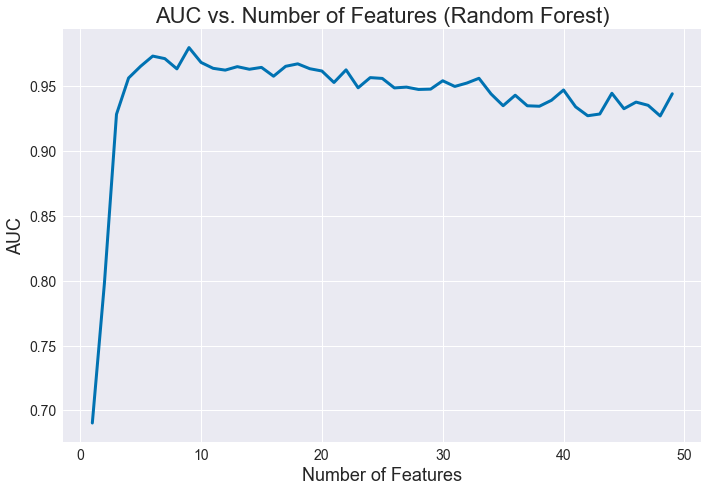

In [6]:
plt.plot(np.arange(1, feat_imp_df.shape[0]), auc_list)
plt.title('AUC vs. Number of Features (Random Forest)')
plt.xlabel('Number of Features')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig('../img/rf_auc_vs_num_feat.png')

# Logistic Regression (LASSO)

Modifying the regularization LASSO parameter results in feature reduction/selection.

In [7]:
coef_df = pd.DataFrame(columns=X_train.columns)

for C_coef in 10**np.arange(3, -5, -0.05):
    logreg_clf = LogisticRegression(C=C_coef, penalty='l1')
    logreg_clf.fit(X_train, y_train)

    coef_df.loc[C_coef] = logreg_clf.coef_[0]

In [8]:
num_feat_df = pd.DataFrame((coef_df != 0).sum(axis=1), columns=['num_feat'])

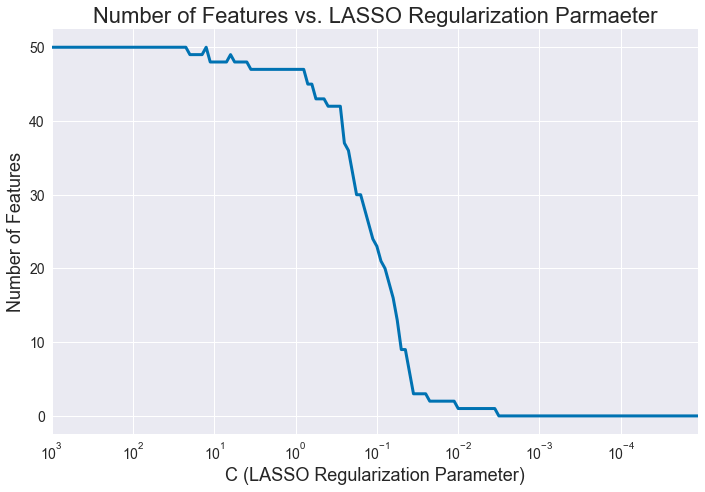

In [9]:
num_feat_df.plot(y='num_feat', logx=True, legend=None)
plt.title('Number of Features vs. LASSO Regularization Parmaeter')
plt.xlabel('C (LASSO Regularization Parameter)')
plt.ylabel('Number of Features')

plt.tight_layout()
plt.savefig('../img/lasso_num_feat.png')

## Showing Parameter Shrinkage

Here, we show how the parameters actually shrink as a result of the LASSO parameter. We will only use 10 features to visualize it.

In [10]:
coef_df = pd.DataFrame(columns=X_train.columns[:10])

for C_coef in 10**np.arange(3, -5, -0.05):
    logreg_clf = LogisticRegression(C=C_coef, penalty='l1')
    logreg_clf.fit(X_train.iloc[:, :10], y_train)

    coef_df.loc[C_coef] = logreg_clf.coef_[0]

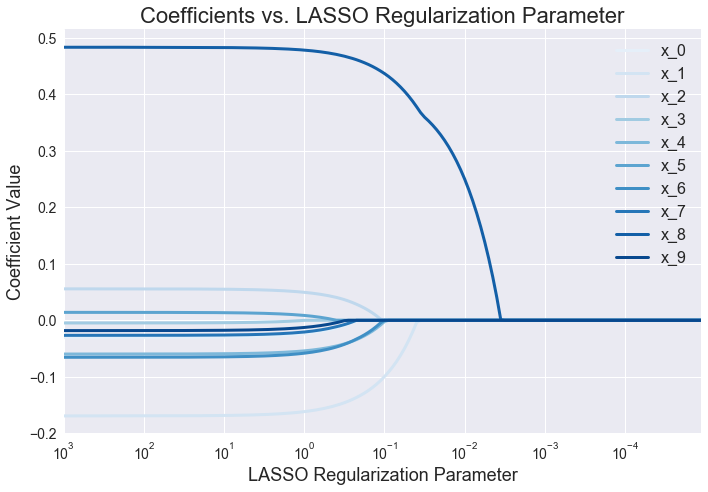

In [11]:
sns.set_palette('Blues', n_colors=10)
coef_df.plot(logx=True)
plt.title('Coefficients vs. LASSO Regularization Parameter')
plt.xlabel('LASSO Regularization Parameter')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.savefig('../img/lasso_coef_value.png')